In [ ]:
import os

In [ ]:
!pip install langgraph langchain langchain-groq langchain-core langchain-community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict,Literal,Annotated
from langgraph.checkpoint.memory import InMemorySaver



In [ ]:
from google.colab import userdata
groq_api_key=userdata.get('GROQ_API_KEY')

In [ ]:
model=ChatGroq(model='llama-3.1-8b-instant',api_key=groq_api_key,max_tokens=100,temperature=0.3)

In [ ]:
class Faultstate(TypedDict):
  input:str
  step1:str
  step2:str
  step3:str

In [ ]:
import time

In [ ]:
def step1(state: Faultstate)->Faultstate:
  print("step 1 is executing and ...")
  return {
      **state,
      'step1':'done',
      'input':state['input']
  }

def step2(state :Faultstate)->Faultstate:
    print("step 2 is executing and crashed the step 2")
    time.sleep(30)
    return{
        **state,
        'step2':'done'
    }
def step3(state :Faultstate)->Faultstate:
      print("step 3 is executing ")
      return{
          **state,
          'step3':'done'
      }

In [ ]:
graph=StateGraph(Faultstate)

In [ ]:
checkpointer=InMemorySaver()

In [ ]:
graph.add_node('step1',step1)
graph.add_node('step2',step2)
graph.add_node('step3',step3)


In [ ]:
graph.add_edge(START,'step1')
graph.add_edge('step1','step2')
graph.add_edge('step2','step3')
graph.add_edge('step3',END)

In [ ]:
workflow=graph.compile(checkpointer=checkpointer)

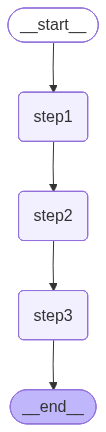

In [ ]:
workflow

In [ ]:
config1={
    'configurable':{'thread_id':'thread-1'}
}


In [ ]:
try:
  print('step 2 crashing')
  workflow.invoke({'input':'start'},config=config1)
except KeyboardInterrupt:
  print("keyboard interrupt occurs....")

step 2 crashing
step 1 is executing and ...
step 2 is executing and crashed the step 2
keyboard interrupt occurs....


In [ ]:
workflow.get_state(config1)

StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step2',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0feae6-7791-6896-8001-0c73f187d543'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-31T14:09:06.223913+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0feae6-778c-65a0-8000-e31c9e01738a'}}, tasks=(PregelTask(id='69fcf4fa-f5ab-4de2-0723-77590905de00', name='step2', path=('__pregel_pull', 'step2'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [ ]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step2',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0feae6-7791-6896-8001-0c73f187d543'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-31T14:09:06.223913+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0feae6-778c-65a0-8000-e31c9e01738a'}}, tasks=(PregelTask(id='69fcf4fa-f5ab-4de2-0723-77590905de00', name='step2', path=('__pregel_pull', 'step2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step1',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0feae6-778c-65a0-8000-e31c9e01738a'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-31T14:09:06.221797+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkp

In [ ]:
workflow.invoke(None,config=config1)

step 2 is executing and crashed the step 2
step 3 is executing 


{'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}

#time travel

In [ ]:
workflow.get_state(config=config1)

StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0feaea-5b65-6fba-8003-05603bb86787'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-01-31T14:10:50.644240+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0feaea-5b62-662e-8002-a915cce791c7'}}, tasks=(), interrupts=())

In [ ]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0feaea-5b65-6fba-8003-05603bb86787'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-01-31T14:10:50.644240+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0feaea-5b62-662e-8002-a915cce791c7'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step3',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0feaea-5b62-662e-8002-a915cce791c7'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-31T14:10:50.642746+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0feae6-7791-6896-8001-0c73f187d543'}}, tasks=(PregelTask(id='b720cdea-0d78-2cee-

In [ ]:
# workflow.update_state({'input':'Rahul'},{'configurable':{'thread_id':'thread-1','checkpoint_id':'1f0feae6-7791-6896-8001-0c73f187d543'}})